In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from EquationModel import CholInducedRKHS

In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])

  0%|          | 0/2019 [00:00<?, ?it/s]

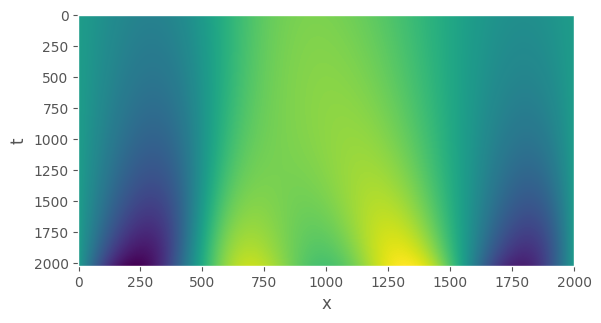

In [3]:
plt.imshow(sols[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)

In [4]:
interp = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interp.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

In [5]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    alpha = 0.6
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary


In [6]:
num_grid_x = 26
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]

u_true = u_true_function(tx_all)

num_obs = 40
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)
x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)


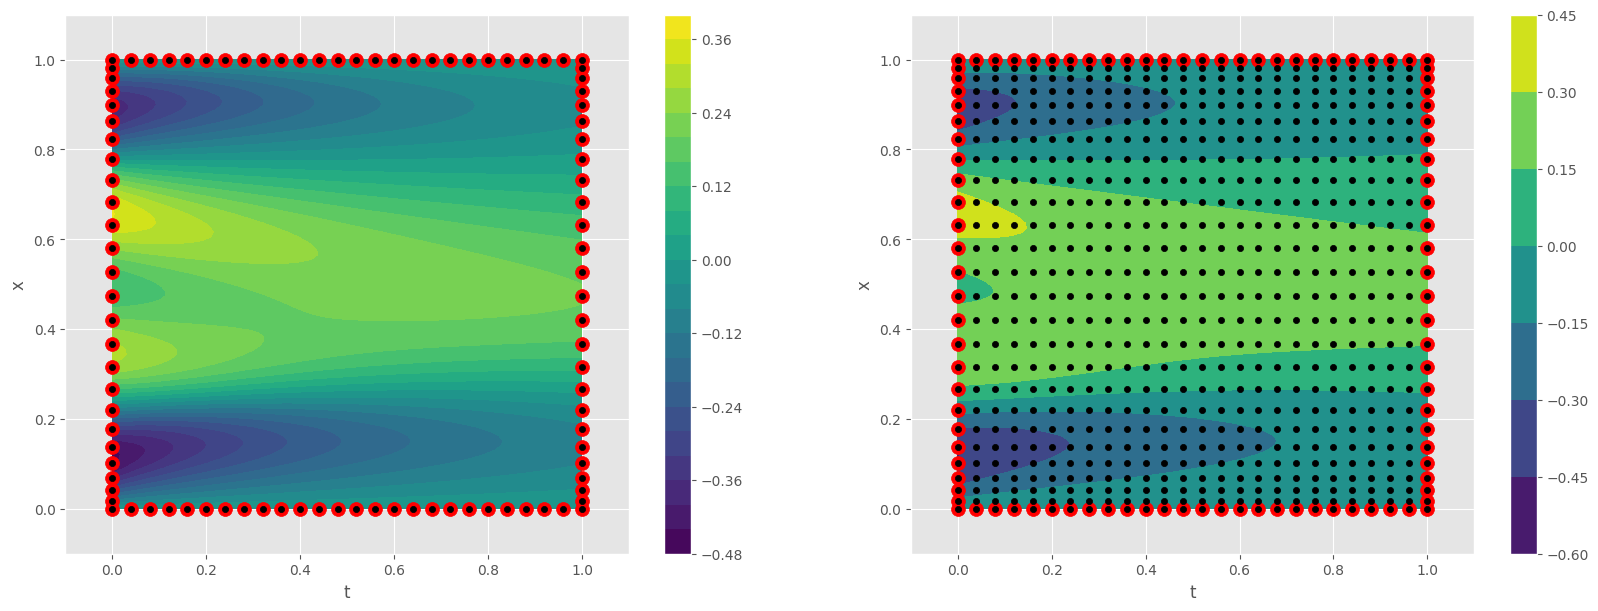

In [7]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

Text(0.5, 1.0, 'Input Data')

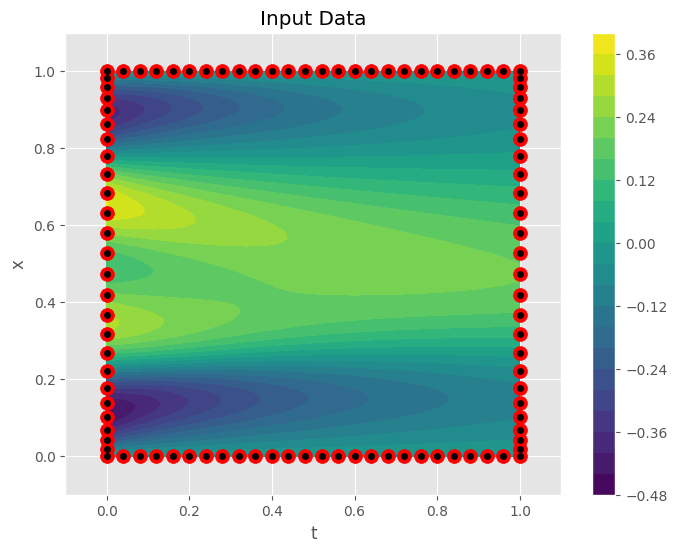

In [8]:
plt.figure(figsize=(8,6))
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

In [9]:
# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,500),jnp.linspace(0,1,500))
# samples = np.random.multivariate_normal(jnp.zeros(len(Kt)),Kt,10)
# plt.figure(figsize=(24,5))
# for s in samples[:2]:
#     plt.plot(jnp.linspace(0,1,500),s)

# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,26),jnp.linspace(0,1,500))
# plt.figure(figsize=(20,5))
# for krow in Kt:
#     plt.plot(krow)

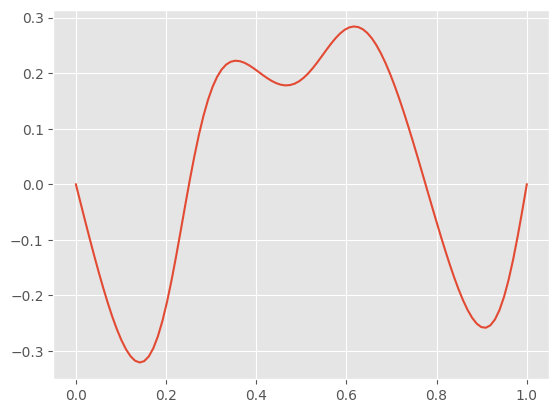

In [10]:
grid_points = jnp.linspace(0,1,100)
plot_views = jnp.vstack([0.2*jnp.ones(100),grid_points]).T

plt.plot(grid_points,u_true_function(plot_views))

In [11]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel

u_operators = tuple([eval_k,dx_k,dt_k])
feature_operators = tuple([eval_k,dx_k,dxx_k])


k_u = get_gaussianRBF(jnp.sqrt(0.025/2))#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

In [12]:
from EquationModel import OperatorPDEModel

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

In [13]:
# init_feats = EqnModel.get_stacked_eqn_features((u_params_init,))
# KP_init = P_model.kernel_function(init_feats,init_feats)
# P_params_init = solve(KP_init+1e-4 * diagpart(KP_init),EqnModel.get_overall_rhs(u_params_init))

In [14]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM
params_init = jnp.hstack([u_params_init,jnp.zeros(P_model.num_params)])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.07329, Jres = 143.5, alpha = 0.1, improvement_ratio = 0.5729
Iteration 1, loss = 0.0257, Jres = 95.97, alpha = 0.1, improvement_ratio = 0.6824
Iteration 2, loss = 0.0139, Jres = 165.6, alpha = 0.1, improvement_ratio = 0.4997
Iteration 3, loss = 0.001793, Jres = 154.5, alpha = 0.08333, improvement_ratio = 0.9603
Iteration 4, loss = 0.0008632, Jres = 36.06, alpha = 0.06944, improvement_ratio = 0.908
Iteration 5, loss = 0.0005362, Jres = 15.25, alpha = 0.05787, improvement_ratio = 0.9981
Iteration 50, loss = 1.099e-06, Jres = 0.2564, alpha = 1.582e-05, improvement_ratio = 0.9276
Line Search Failed!
Final Iteration Results
Iteration 94, loss = 1.19e-07, Jres = 0.0002615, alpha = 0.002082


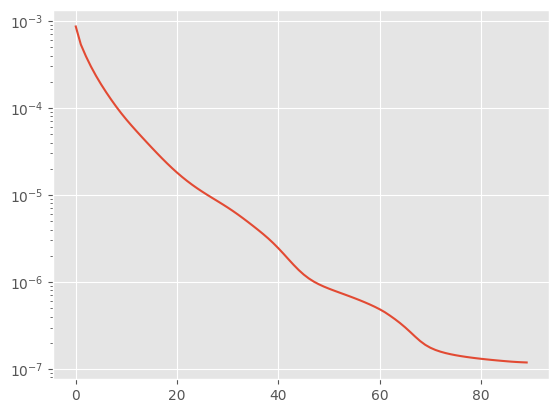

In [15]:
plt.plot(loss_vals[5:])
plt.yscale('log')

In [16]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

In [22]:
importlib.reload(Optimizers)
from Optimizers import SVD_LM
p_adjusted,refinement_losses,reg_vals = SVD_LM(params,EqnModel,1e-5,500)

  0%|          | 0/500 [00:00<?, ?it/s]

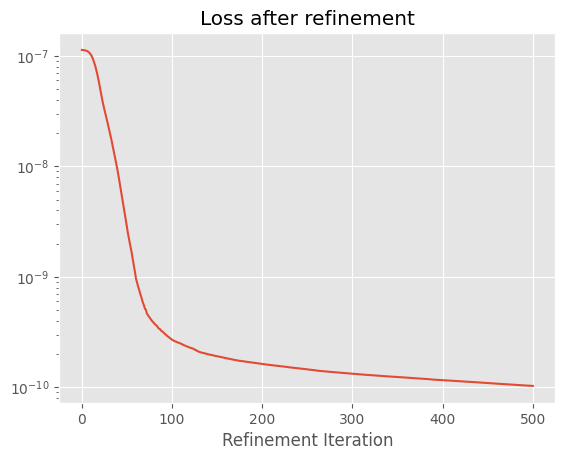

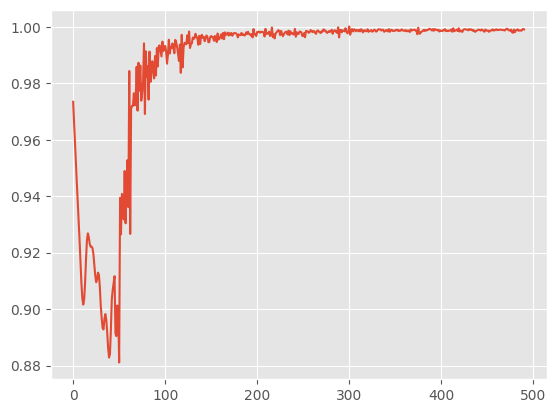

In [23]:
plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')
plt.show()
plt.plot(refinement_losses[10:]/refinement_losses[9:-1])

/tmp/ipykernel_3189639/811041060.py:1: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([loss_vals,refinement_losses]))


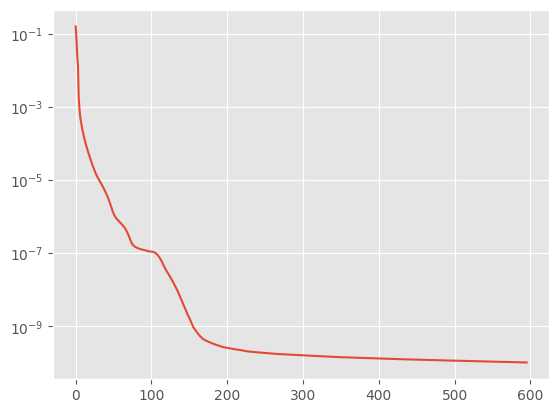

In [24]:
plt.plot(jnp.hstack([loss_vals,refinement_losses]))
plt.yscale('log')

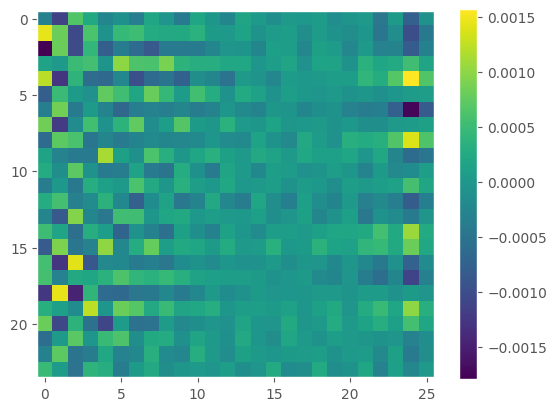

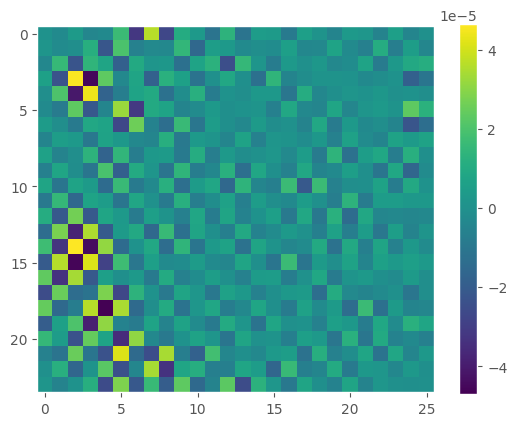

Pre Refinement  1.6927269550183395e-07
Post Refinement  1.6413726291784325e-10


In [25]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [26]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

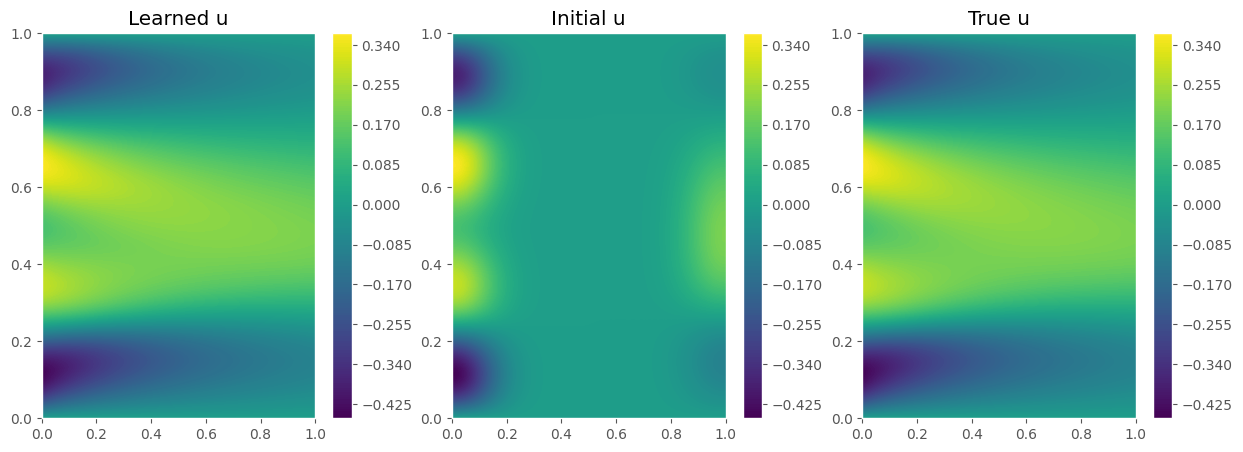

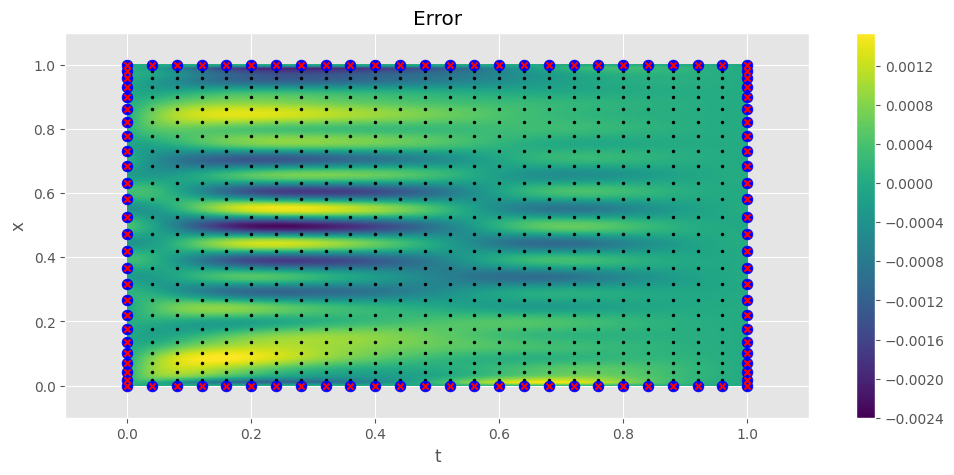

In [27]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [28]:
def compare_values(x,y):
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue',lw = 0.8)
    plt.scatter(x,y,c = 'black',s = 4)


In [29]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

2024-06-06 11:22:28.371778: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.10 = f64[10000,676]{1,0} reduce(f64[10000,676,2]{2,1,0} %broadcast.337, f64[] %constant.16), dimensions={2}, to_apply=%region_10.131, metadata={op_name="jit(get_single_eqn_features)/jit(main)/jit(evaluate_operators)/reduce_sum[axes=(2,)]" source_file="/home/alexh/KEQL/keql/keql_tools/Kernels.py" source_line=34}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-06 11:22:40.522551: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 13.150900562s
Constant folding an instruc

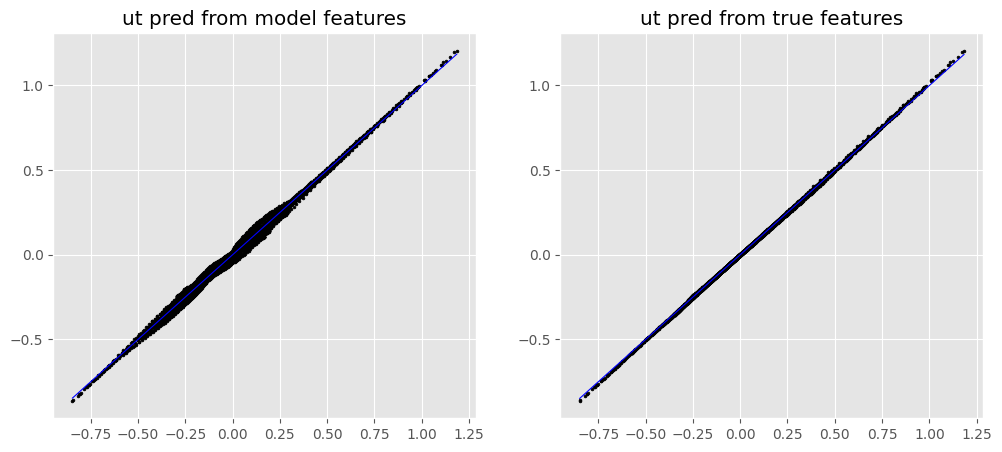

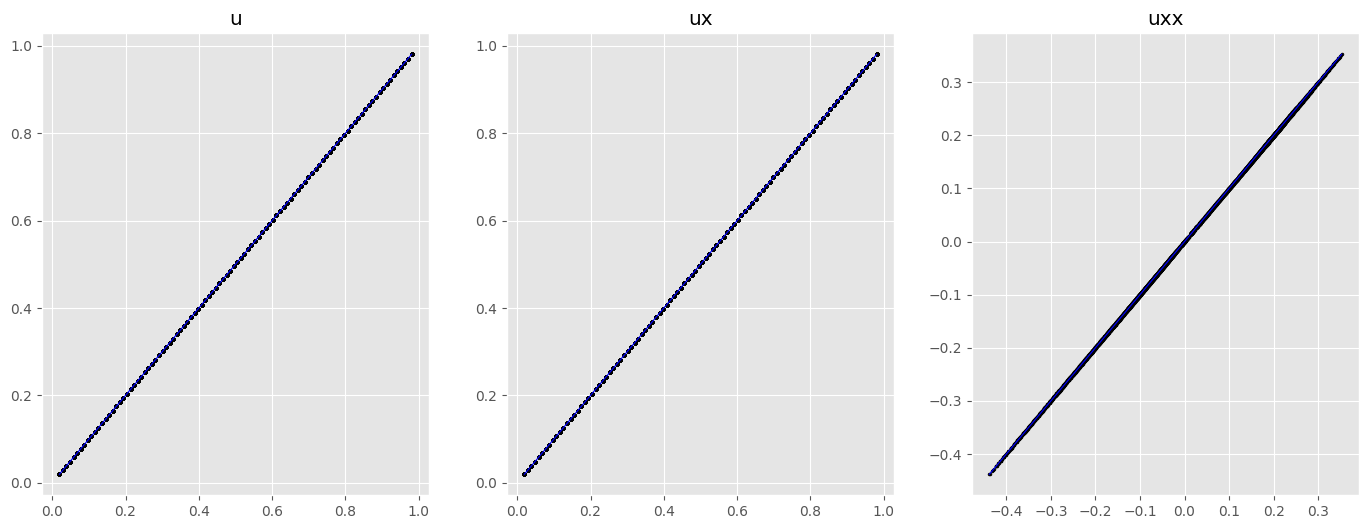

In [30]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


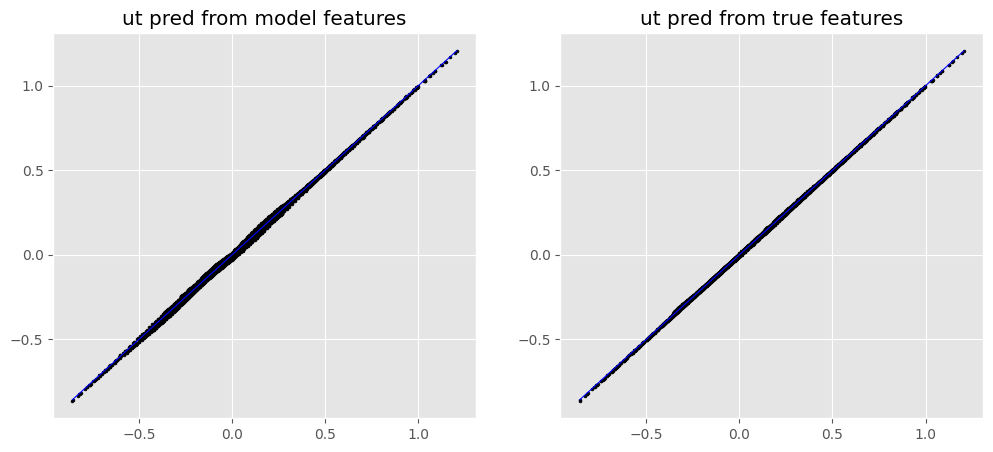

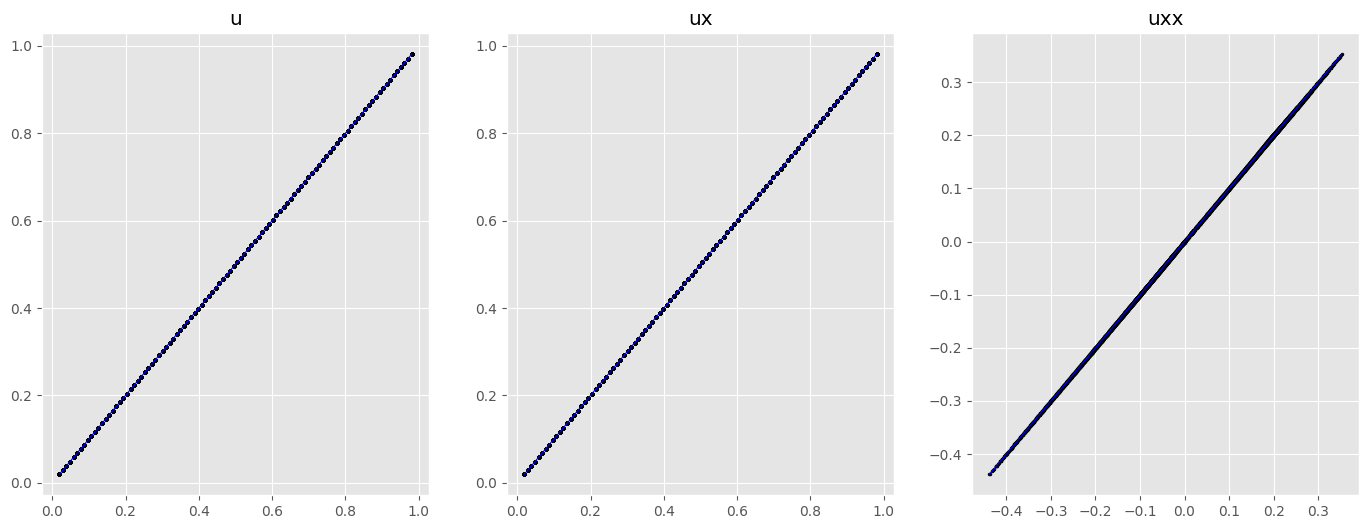

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [31]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  0.05996952928538357
Optimized true feature predictions  0.013095934737885803
2 step model feature predictions  2.509794354480195
2 step true feature predictions  2.4791093539336724
2 step init model feature predictions  30193.745603788095
Clipped Normalized RMSE
Optimized model feature predictions  0.06176530743380463
Optimized true feature predictions  0.012570743865367764
2 step model feature predictions  2.531015252071958
2 step true feature predictions  2.4936497208936275
2 step init model feature predictions  28032.871272671655
Normalized MAE
Optimized model feature predictions  0.052312652128526656
Optimized true feature predictions  0.009675853335717426
2 step model feature predictions  2.4491600371771405
2 step true feature predictions  2.400364279035037
2 step init model feature predictions  11536.517498116487


In [ ]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  0.03210449017115557
Optimized true feature predictions  0.01133524535717602
2 step model feature predictions  2.4909327714989318
2 step true feature predictions  2.4791093533388744
2 step init model feature predictions  30193.745589904378
Clipped Normalized RMSE
Optimized model feature predictions  0.03311318049302231
Optimized true feature predictions  0.011687616440268812
2 step model feature predictions  2.512027022187502
2 step true feature predictions  2.493649720460129
2 step init model feature predictions  28032.87126375705
Normalized MAE
Optimized model feature predictions  0.027571009151836766
Optimized true feature predictions  0.009724484620030166
2 step model feature predictions  2.4228239990099136
2 step true feature predictions  2.4003642784753665
2 step init model feature predictions  11536.517492841156


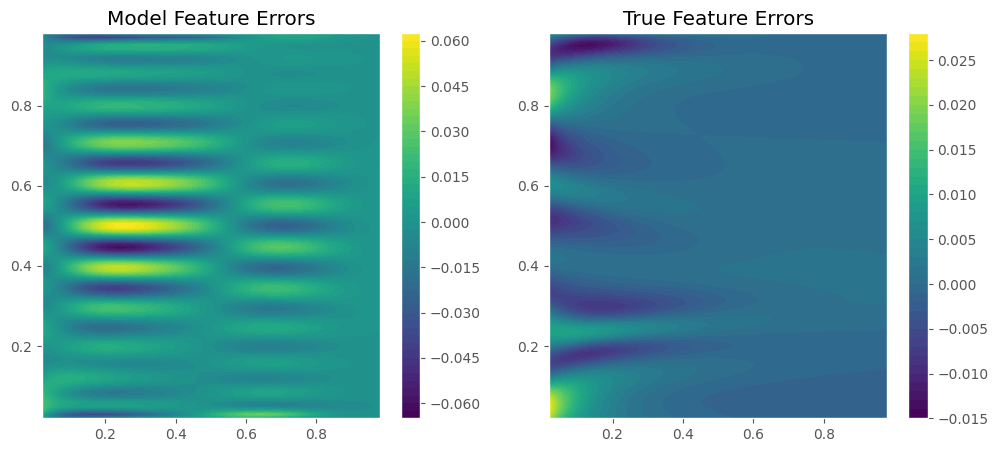

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Model Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,50,)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_true_features,50,)
plt.colorbar()

plt.show()

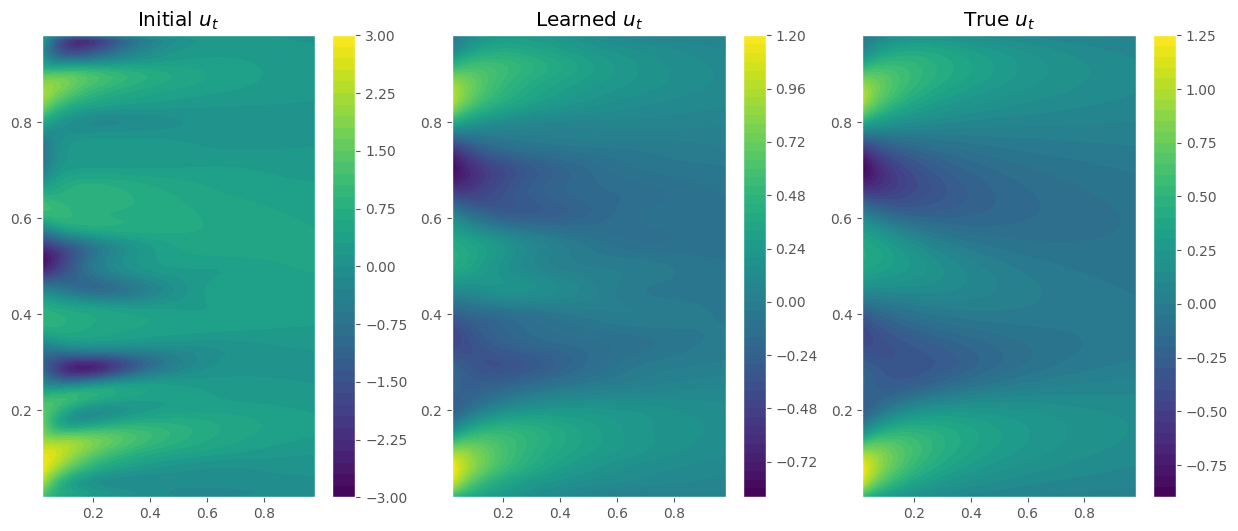

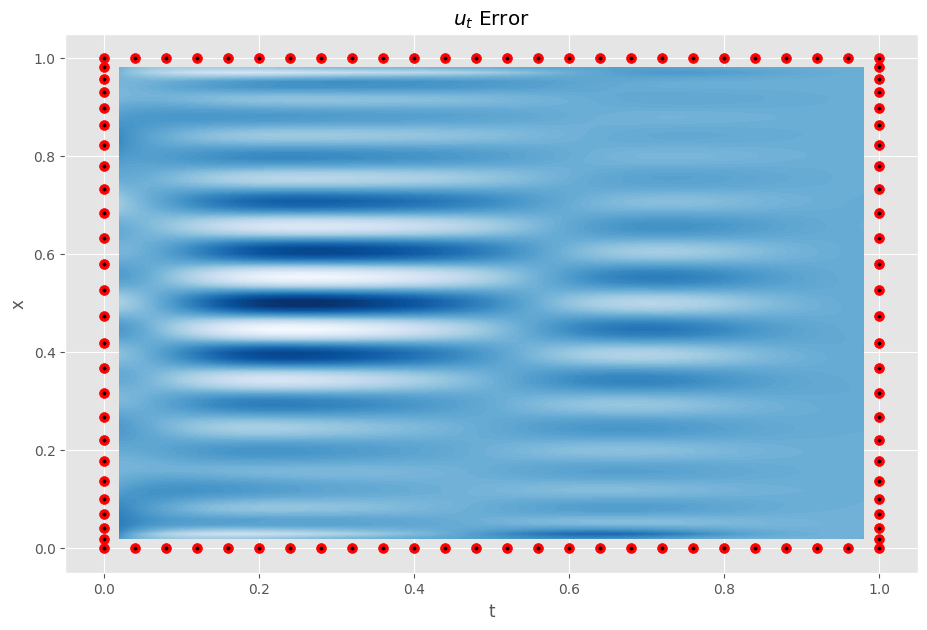

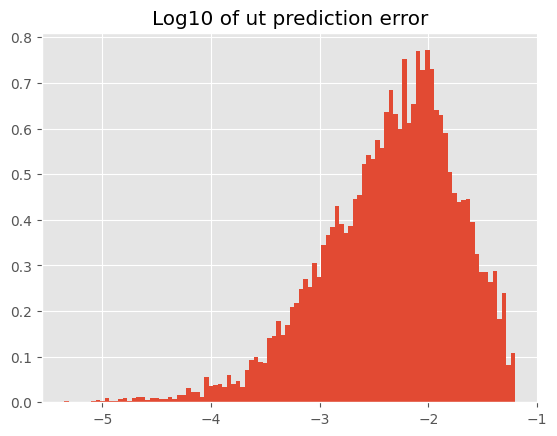

In [33]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

## Test on a new initial condition

  0%|          | 0/2019 [00:00<?, ?it/s]

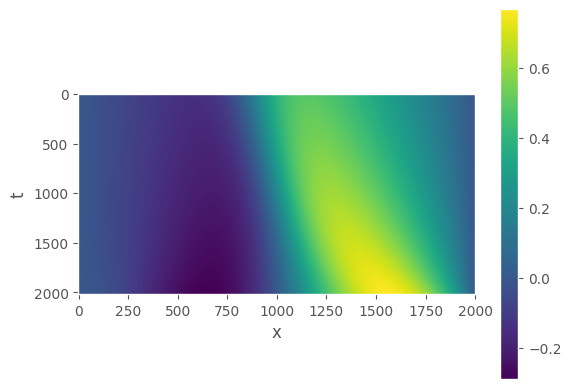

In [34]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def new_func_u0(x):
    u0 = -1 * x * jnp.sin(2 * jnp.pi * x)
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0_new = new_func_u0(grid)[1:-1]

sols_new,tvals = solver(u0_new,1.01)
sols_new = np.hstack([np.zeros((len(sols_new),1)),sols_new,np.zeros((len(sols_new),1))])

new_interp = RectBivariateSpline(tvals,grid,sols_new)
def new_u_true_function(x):
    return new_interp(x[:,0],x[:,1],grid = False)


plt.imshow(sols_new[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [119]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol




num_grid_x = 35
num_grid_t = 50

pde_tx_int,pde_tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

pde_tx_all = jnp.vstack([tx_bdy,tx_int])


tx_init_bdy = jnp.vstack([pde_tx_int[pde_tx_int[:,0]==0],pde_tx_bdy])
new_obs = new_u_true_function(tx_init_bdy)

pde_u_model = CholInducedRKHS(
    pde_tx_all,
    feature_operators,
    k_u
    )

class PdeModel():
    datafit_weight = 25.
    @jit
    def get_grid_features(u_params):
        evaluation = pde_u_model.evaluate_operators(feature_operators,pde_tx_int,u_params)
        grid_features = evaluation.reshape(len(pde_tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([pde_tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return pde_u_model.evaluate_operators((dt_k,),pde_tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return pde_u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return pde_u_model.get_damping()

In [120]:
new_u_init = 0*u_sol

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = CholeskyLM(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.03588, Jres = 28.21, alpha = 0.04167, improvement_ratio = 0.9978
Iteration 1, loss = 0.004206, Jres = 0.1896, alpha = 0.03472, improvement_ratio = 0.9773
Iteration 2, loss = 0.001478, Jres = 0.02153, alpha = 0.02894, improvement_ratio = 0.9982
Iteration 3, loss = 0.0007911, Jres = 0.007601, alpha = 0.02411, improvement_ratio = 1.004
Iteration 4, loss = 0.0005359, Jres = 0.003739, alpha = 0.02009, improvement_ratio = 1.003
Iteration 5, loss = 0.000408, Jres = 0.002181, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0001655, Jres = 0.0005522, alpha = 0.006729, improvement_ratio = 0.9998
Iteration 20, loss = 5.193e-05, Jres = 8.941e-05, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 2.282e-05, Jres = 2.225e-05, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 1.076e-05, Jres = 5.737e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 5.691e-06, Jres = 1.509e-06, alpha = 4.579e-06, improvement_ratio

In [123]:
# reg_sequence = np.hstack(
#     [
#         10 ** jnp.arange(-4, -11, -0.25),
#         5e-12 * np.ones(10),
#         1e-15 * np.ones(5),
#         5e-16 * np.ones(15),
#         1e-16 * np.ones(15),
#         ]
#         )
u_pde_adj,refinement_losses_pde,reg_vals = SVD_LM(u_params_pde,PdeModel,1e-7,100)


  0%|          | 0/100 [00:00<?, ?it/s]

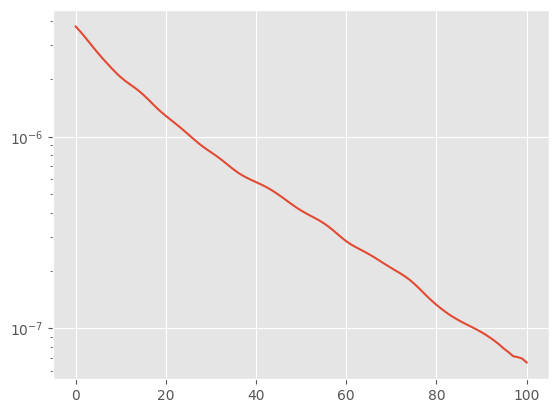

In [124]:
plt.plot(refinement_losses_pde)
plt.yscale('log')

Whole domain NRMSE:  0.007703582341958445
T=1 NRMSE:  0.01254844575547396


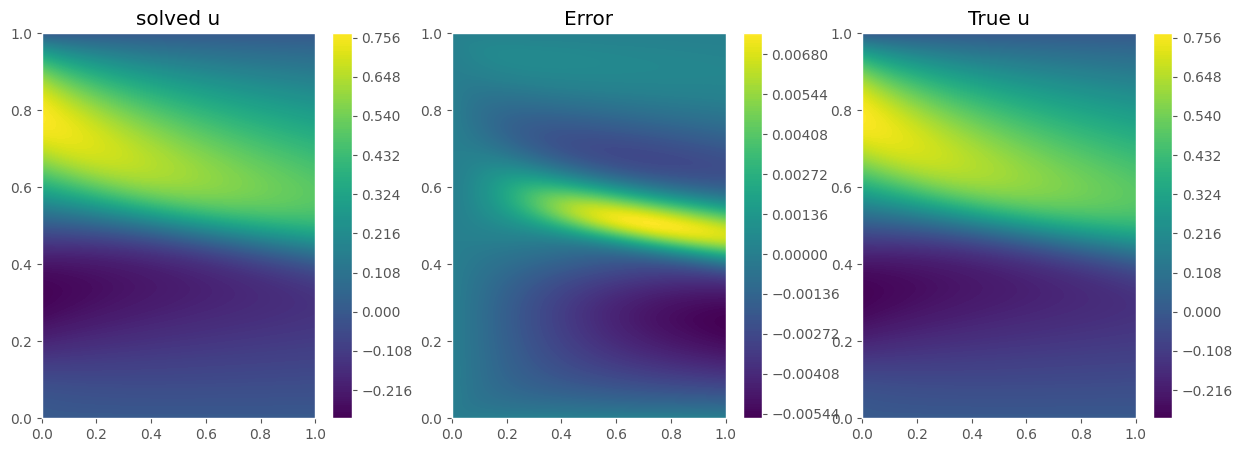

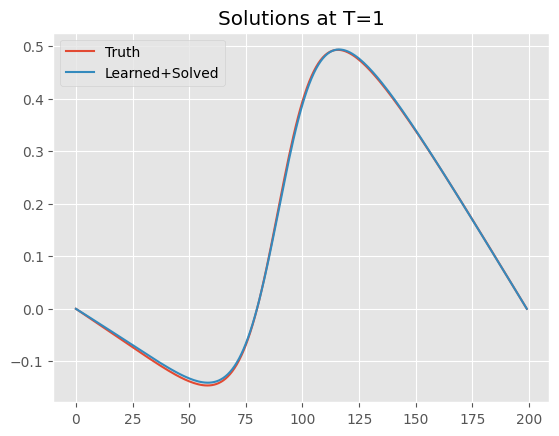

In [127]:
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

new_u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_pde_adj)

new_u_true_fine = new_u_true_function(tx_grid_fine)
print("Whole domain NRMSE: ",get_nrmse(new_u_true_fine,new_u_eval_fine))
print("T=1 NRMSE: ",get_nrmse(new_u_true_fine[tx_grid_fine[:,0]==1],new_u_eval_fine[tx_grid_fine[:,0]==1]))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("solved u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)

plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine,200)
plt.colorbar()
plt.show()

plt.title("Solutions at T=1")
plt.plot(new_u_true_fine[tx_grid_fine[:,0]==1],label = 'Truth')
plt.plot(new_u_eval_fine[tx_grid_fine[:,0]==1],label = "Learned+Solved")
plt.legend()
plt.show()

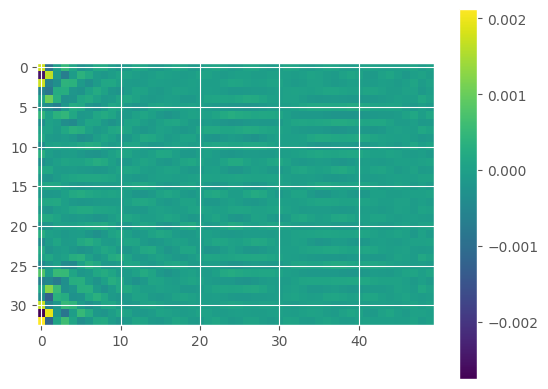

In [126]:
plt.imshow(PdeModel.equation_residual(u_pde_adj).reshape(num_grid_x-2,num_grid_t))
plt.colorbar()